# Heart Data Set
#### Logistic Regression

In [0]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

In [0]:
data=pd.read_csv('Heart.csv',index_col=0)

In [79]:
data.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [80]:
data.dtypes

Age            int64
Sex            int64
ChestPain     object
RestBP         int64
Chol           int64
Fbs            int64
RestECG        int64
MaxHR          int64
ExAng          int64
Oldpeak      float64
Slope          int64
Ca           float64
Thal          object
AHD           object
dtype: object

## Data Preprocessing

In [0]:
data['AHD'].replace(['No','Yes'],[1,0],inplace=True)
    

In [82]:
data.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,1
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,0
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,0
4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,1
5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,1


In [83]:
data.describe()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,AHD
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,303.000000
mean,54.438944,0.679868,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,0.541254
std,9.038662,0.467299,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,0.499120
min,29.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,48.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,56.000000,1.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,1.000000
75%,61.000000,1.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,1.000000
max,77.000000,1.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,1.000000


Checking for null values

In [84]:
data.isnull().sum()

Age          0
Sex          0
ChestPain    0
RestBP       0
Chol         0
Fbs          0
RestECG      0
MaxHR        0
ExAng        0
Oldpeak      0
Slope        0
Ca           4
Thal         2
AHD          0
dtype: int64

## Treating Null Values

NaN treating for Ca colums

In [86]:
data['Ca'].mode()

0    0.0
dtype: float64

In [87]:
from sklearn.preprocessing import Imputer
imputer=Imputer(missing_values="NaN", strategy="median" )

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


# Feature Engineering

In [142]:
import statsmodels.api as sm
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):

    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [143]:
stepwise_selection(x,y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


Add  Thal_normal                    with p-value 1.18344e-22
Add  ChestPain_asymptomatic         with p-value 6.11892e-14
Add  Ca                             with p-value 3.5056e-10
Add  Oldpeak                        with p-value 0.000396969
Add  ExAng                          with p-value 0.00209766


['Thal_normal', 'ChestPain_asymptomatic', 'Ca', 'Oldpeak', 'ExAng']

In [0]:
data["Ca"]=imputer.fit_transform(data[["Ca"]]).ravel()

In [89]:
data.isnull().sum()

Age          0
Sex          0
ChestPain    0
RestBP       0
Chol         0
Fbs          0
RestECG      0
MaxHR        0
ExAng        0
Oldpeak      0
Slope        0
Ca           0
Thal         2
AHD          0
dtype: int64

##NaN Treatment for Thal

In [0]:
data.dropna(inplace=True)

In [91]:
data.isnull().sum()

Age          0
Sex          0
ChestPain    0
RestBP       0
Chol         0
Fbs          0
RestECG      0
MaxHR        0
ExAng        0
Oldpeak      0
Slope        0
Ca           0
Thal         0
AHD          0
dtype: int64

In [98]:
data['Ca'].dtypes

dtype('float64')

## Checking Unique for categorical variables

In [101]:
for col in data.columns:
#   print(data[col].dtypes)
  if(data[col].dtypes==object):    
    uni=data[col].unique()
    print(col,uni)
    print('***********')

ChestPain ['typical' 'asymptomatic' 'nonanginal' 'nontypical']
***********
Thal ['fixed' 'normal' 'reversable']
***********


#### Dummification Process

In [93]:
heart=pd.get_dummies(data)
heart.head()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,AHD,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable
1,63,1,145,233,1,2,150,0,2.3,3,0.0,1,0,0,0,1,1,0,0
2,67,1,160,286,0,2,108,1,1.5,2,3.0,0,1,0,0,0,0,1,0
3,67,1,120,229,0,2,129,1,2.6,2,2.0,0,1,0,0,0,0,0,1
4,37,1,130,250,0,0,187,0,3.5,3,0.0,1,0,1,0,0,0,1,0
5,41,0,130,204,0,2,172,0,1.4,1,0.0,1,0,0,1,0,0,1,0


In [105]:
heart.columns

Index(['Age', 'Sex', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR', 'ExAng',
       'Oldpeak', 'Slope', 'Ca', 'AHD', 'ChestPain_asymptomatic',
       'ChestPain_nonanginal', 'ChestPain_typical', 'Thal_fixed',
       'Thal_normal'],
      dtype='object')

In [0]:
heart.drop(columns=['ChestPain_nontypical','Thal_reversable'],inplace=True)

#Model Buliding

In [0]:
x=heart.drop('AHD',axis=1)
y=heart['AHD']

In [0]:
LR=LogisticRegression(penalty='l1')

In [117]:
LR.fit(x,y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
pred_y=LR.predict(x)

In [0]:
from sklearn.metrics import accuracy_score,precision_score,recall_score

In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import *

In [120]:
accuracy_score(y,pred_y)

0.8737541528239202

# KFold

In [131]:
from sklearn.model_selection import KFold
import numpy as np
kf = KFold(n_splits=5,shuffle=True,random_state=2)
acc=[]
pre=[]
recall=[]
for train,test in kf.split(x,y):
    M = LogisticRegression(penalty='l2')
    xtrain,xtest = x[train,:],x[test,:]
    ytrain,ytest = y[train],y[test]
    M.fit(xtrain,ytrain)
    ypredict = M.predict(xtest)
    acc.append(accuracy_score(ytest,ypredict))
    pre.append(precision_score(ytest,ypredict))
    recall.append(recall_score(ytest,ypredict))
print('Cross validation score:%.2f%%'%np.mean(acc))
print('Accuracy score:%.2f%%'%np.mean(pre))
print('Recall score:%.2f%%'%np.mean(recall))

Cross validation score:0.85%
Accuracy score:0.85%
Recall score:0.90%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [127]:
confusion_matrix(y,pred_y) # Confusion matrix

array([[113,  25],
       [ 13, 150]])

In [129]:
print(classification_report(y,pred_y))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86       138
           1       0.86      0.92      0.89       163

   micro avg       0.87      0.87      0.87       301
   macro avg       0.88      0.87      0.87       301
weighted avg       0.88      0.87      0.87       301



#ROC

0.8695429892415755


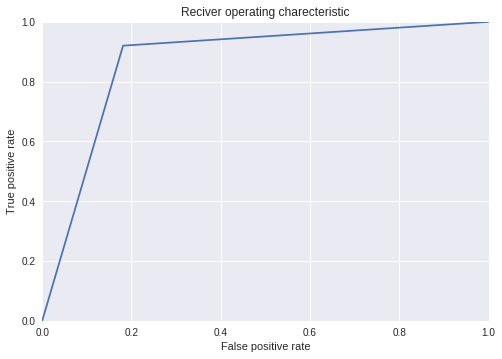

In [137]:
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
fpr,tpr,_ =roc_curve(y,pred_y) #  roc_curve(ytest,ypredict of confusion)--> Confusion matric result
roc_auc = auc(fpr,tpr)
print(roc_auc)
plt.figure()
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Reciver operating charecteristic')
plt.show()

# Model Predicting 2

In [0]:
col_to_use=['Thal_normal', 'ChestPain_asymptomatic', 'Ca', 'Oldpeak', 'ExAng']
x=heart[col_to_use]
y=heart['AHD']

In [146]:
LR1=LR.fit(x,y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [148]:
LR1.predict(x)

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1]

In [149]:
accuracy_score(y,pred_y)

0.8737541528239202

# K Fold

In [151]:
x=x.values
y=y.values
from sklearn.model_selection import KFold
import numpy as np
kf = KFold(n_splits=5,shuffle=True,random_state=2)
acc=[]
pre=[]
recall=[]
for train,test in kf.split(x,y):
    M = LogisticRegression(penalty='l2')
    xtrain,xtest = x[train,:],x[test,:]
    ytrain,ytest = y[train],y[test]
    M.fit(xtrain,ytrain)
    ypredict = M.predict(xtest)
    acc.append(accuracy_score(ytest,ypredict))
    pre.append(precision_score(ytest,ypredict))
    recall.append(recall_score(ytest,ypredict))
print('Cross validation score:%.2f%%'%np.mean(acc))
print('Accuracy score:%.2f%%'%np.mean(pre))
print('Recall score:%.2f%%'%np.mean(recall))

Cross validation score:0.84%
Accuracy score:0.84%
Recall score:0.88%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

#ROC

0.8028571428571428


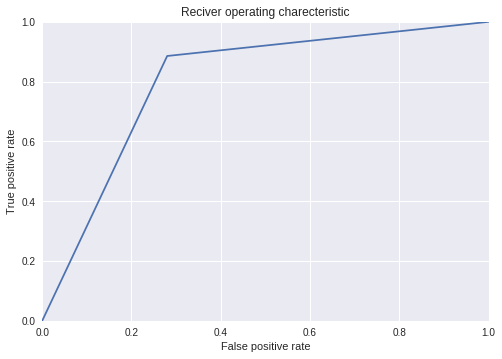

In [153]:
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
fpr,tpr,_ =roc_curve(ytest,ypredict) #  roc_curve(ytest,ypredict of confusion)--> Confusion matric result
roc_auc = auc(fpr,tpr)
print(roc_auc)
plt.figure()
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Reciver operating charecteristic')
plt.show()

# Feature engineering_1

In [157]:
data.dtypes

Age            int64
Sex            int64
ChestPain     object
RestBP         int64
Chol           int64
Fbs            int64
RestECG        int64
MaxHR          int64
ExAng          int64
Oldpeak      float64
Slope          int64
Ca           float64
Thal          object
AHD            int64
dtype: object

In [158]:
data.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,1
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,0
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,0
4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,1
5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,1


In [0]:
df=data[['Age','RestBP','Chol','MaxHR','Oldpeak','Slope','Ca']]

In [0]:
normalized_df=(df-df.mean())/df.std()

In [0]:
data=data.drop(['Age','RestBP','Chol','MaxHR','Oldpeak','Slope','Ca'],axis=1)

In [0]:
data=pd.concat([data,normalized_df],axis=1)

In [164]:
data.head()

,Sex,ChestPain,Fbs,RestECG,ExAng,Thal,AHD,Age,RestBP,Chol,MaxHR,Oldpeak,Slope,Ca
1,1,typical,1,2,0,fixed,1,0.942752,0.752487,-0.268741,0.013079,1.080306,2.267359,-0.713504
2,1,asymptomatic,0,2,1,normal,0,1.383899,1.602070,0.753244,-1.824125,0.392657,0.646278,2.491938
3,1,asymptomatic,0,2,1,reversable,0,1.383899,-0.663484,-0.345872,-0.905523,1.338175,0.646278,1.423457
4,1,nonanginal,0,0,0,normal,1,-1.924708,-0.097095,0.059065,1.631569,2.111780,2.267359,-0.713504
5,0,nontypical,0,2,0,normal,1,-1.483561,-0.097095,-0.827940,0.975425,0.306701,-0.974803,-0.713504


#Dummification

In [165]:
heart=pd.get_dummies(data)
heart.head()

,Sex,Fbs,RestECG,ExAng,AHD,Age,RestBP,Chol,MaxHR,Oldpeak,Slope,Ca,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable
1,1,1,2,0,1,0.942752,0.752487,-0.268741,0.013079,1.080306,2.267359,-0.713504,0,0,0,1,1,0,0
2,1,0,2,1,0,1.383899,1.602070,0.753244,-1.824125,0.392657,0.646278,2.491938,1,0,0,0,0,1,0
3,1,0,2,1,0,1.383899,-0.663484,-0.345872,-0.905523,1.338175,0.646278,1.423457,1,0,0,0,0,0,1
4,1,0,0,0,1,-1.924708,-0.097095,0.059065,1.631569,2.111780,2.267359,-0.713504,0,1,0,0,0,1,0
5,0,0,2,0,1,-1.483561,-0.097095,-0.827940,0.975425,0.306701,-0.974803,-0.713504,0,0,1,0,0,1,0


In [0]:
heart.drop(columns=['ChestPain_nontypical','Thal_reversable'],inplace=True)

# Model Buliding

In [0]:
x=heart.drop('AHD',axis=1)
y=heart['AHD']

In [168]:
LR.fit(x,y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
pred_y=LR.predict(x)

In [170]:
accuracy_score(y,pred_y)

0.8704318936877077

In [171]:
x=x.values
y=y.values
from sklearn.model_selection import KFold
import numpy as np
kf = KFold(n_splits=5,shuffle=True,random_state=2)
acc=[]
pre=[]
recall=[]
for train,test in kf.split(x,y):
    M = LogisticRegression(penalty='l2')
    xtrain,xtest = x[train,:],x[test,:]
    ytrain,ytest = y[train],y[test]
    M.fit(xtrain,ytrain)
    ypredict = M.predict(xtest)
    acc.append(accuracy_score(ytest,ypredict))
    pre.append(precision_score(ytest,ypredict))
    recall.append(recall_score(ytest,ypredict))
print('Cross validation score:%.2f%%'%np.mean(acc))
print('Accuracy score:%.2f%%'%np.mean(pre))
print('Recall score:%.2f%%'%np.mean(recall))

Cross validation score:0.85%
Accuracy score:0.84%
Recall score:0.89%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

0.8171428571428571


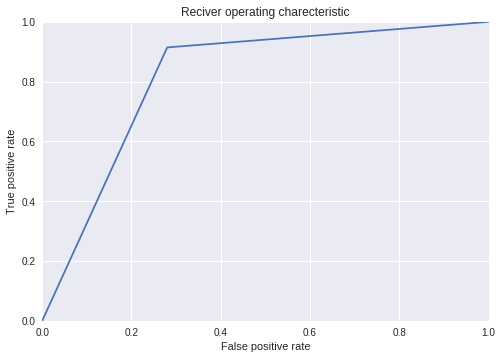

In [172]:
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
fpr,tpr,_ =roc_curve(ytest,ypredict) #  roc_curve(ytest,ypredict of confusion)--> Confusion matric result
roc_auc = auc(fpr,tpr)
print(roc_auc)
plt.figure()
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Reciver operating charecteristic')
plt.show()

# SMOTE

In [190]:
from sklearn.model_selection import train_test_split 
X = heart.loc[:, heart.columns != 'AHD']
y = heart.loc[:, heart.columns == 'AHD']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  226
Number of no subscription in oversampled data 113
Number of subscription 113
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#RFE --> Recursive Feature Elimination

In [193]:
data_final_vars=heart.columns.values.tolist()
y=['AHD']
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 6)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)
print(data_final_vars)

[False False False  True False False False False False False  True  True
  True False  True  True]
[ 2  6  9  1 11  4 10  7  5  3  1  1  1  8  1  1]
['Sex', 'Fbs', 'RestECG', 'ExAng', 'AHD', 'Age', 'RestBP', 'Chol', 'MaxHR', 'Oldpeak', 'Slope', 'Ca', 'ChestPain_asymptomatic', 'ChestPain_nonanginal', 'ChestPain_typical', 'Thal_fixed', 'Thal_normal']


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

# Feature Selection

In [196]:
import statsmodels.api as sm
logit_model=sm.Logit(y,x)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.328131
         Iterations 7
                            Results: Logit
Model:                 Logit              No. Iterations:     7.0000  
Dependent Variable:    AHD                Pseudo R-squared:   0.524   
Date:                  2019-02-02 16:55   AIC:                229.5351
No. Observations:      301                BIC:                288.8489
Df Model:              15                 Log-Likelihood:     -98.768 
Df Residuals:          285                LL-Null:            -207.60 
Converged:             1.0000             Scale:              1.0000  
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
Sex                    -1.0882   0.4062 -2.6791 0.0074 -1.8843 -0.2921
Fbs                     0.5645   0.5909  0.9553 0.3394 -0.5937  1.7228
Res

 p-values should be less than 0.05

In [0]:
col=['Sex','RestBP','MaxHR','Ca','ChestPain_nonanginal','Thal_fixed','Thal_normal']

In [0]:
x=heart[col]

In [199]:
import statsmodels.api as sm
logit_model=sm.Logit(y,x)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.392557
         Iterations 7
                           Results: Logit
Model:                 Logit             No. Iterations:    7.0000  
Dependent Variable:    AHD               Pseudo R-squared:  0.431   
Date:                  2019-02-02 17:04  AIC:               250.3193
No. Observations:      301               BIC:               276.2691
Df Model:              6                 Log-Likelihood:    -118.16 
Df Residuals:          294               LL-Null:           -207.60 
Converged:             1.0000            Scale:             1.0000  
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Sex                  -1.3482   0.2525 -5.3395 0.0000 -1.8430 -0.8533
RestBP               -0.3488   0.1595 -2.1873 0.0287 -0.6613 -0.0363
MaxHR                 0.8643

In [0]:
# col=['Sex','RestBP','MaxHR','Ca','ChestPain_nonanginal','Thal_normal']
x=heart[col]

In [203]:
import statsmodels.api as sm
logit_model=sm.Logit(y,x)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.396524
         Iterations 7
                           Results: Logit
Model:                 Logit             No. Iterations:    7.0000  
Dependent Variable:    AHD               Pseudo R-squared:  0.425   
Date:                  2019-02-02 17:05  AIC:               250.7076
No. Observations:      301               BIC:               272.9502
Df Model:              5                 Log-Likelihood:    -119.35 
Df Residuals:          295               LL-Null:           -207.60 
Converged:             1.0000            Scale:             1.0000  
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Sex                  -1.2226   0.2341 -5.2230 0.0000 -1.6813 -0.7638
RestBP               -0.3343   0.1586 -2.1072 0.0351 -0.6453 -0.0234
MaxHR                 0.8191

In [204]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
pred_y=logreg.predict(X_test)

In [206]:
accuracy_score(pred_y,y_test)

0.8241758241758241

In [207]:
logreg.score(X_test,y_test)

0.8241758241758241